# Introduction

## Weighted 3-SAT

The maximum satisfiability problem (MAX-SAT) is the problem of determining the maximum number of clauses, of a given Boolean formula in conjunctive normal form, that can be made true by an assignment of truth values to the variables of the formula. It is a generalization of the Boolean satisfiability problem, which asks whether there exists a truth assignment that makes all clauses true.

More generally, one can define a weighted version of MAX-SAT as follows: 

* Given a conjunctive normal form (CNF) formula with non-negative weights assigned to each clause, find truth values for its variables that maximize the combined weight of the satisfied clauses. 

*The MAX-SAT problem is an instance of weighted MAX-SAT where all weights are 1.*

In this task, I will introduce Tabu Search heuristic, solving Weighted SAT, containing 3 literals in each clause. Data are in [DIMACS](https://www.cs.ubc.ca/~hoos/SATLIB/benchm.html) format, 

## Description

* **Search space:** set of all truth assignments for propositional variables in given CNF formula F (bit-array)
* **Solution set:** certificates (bit-arrays) with maximal weight.
* **Initialisation:** random picking, i.e., select uniformly at random from set of all truth assignments.
* **Termination:** after given bound on number of search steps has been reached *or* upon finding apriori optimal weight for F (for less time consumption).

# Tabu Search algorithm (TS)

## Key idea: 

* Use aspects of search history (memory) to escape from local minima.

**Simple Tabu Search:**

1. Associate tabu attributes with candidate solutions or solution components.
2. Forbid steps to search positions recently visited by underlying iterative best improvement procedure based on tabu attributes.

Non-tabu search positions in N(s) are called admissible neighbours of s.

After a search step, the current search position or the solution components just added/removed from it are declared tabu for a fixed number of subsequent search steps (tabu tenure (*tt*)).

An additional aspiration criterion is used: this specifies conditions under which tabu status may be overridden (e.g., if considered step leads to improvement in incumbent solution).

1-flip neighbourhood relation, i.e., two truth assignments are neighbours if they differ in the truth value assigned to one variable.

**Search steps:**

1. variables are tabu if they have been changed in the last tt steps
2. neighbouring assignments are admissible if they can be reached by changing the value of a non-tabu variable or have fewer unsatisfied clauses than the best assignment seen so far (aspiration criterion)
3. choose uniformly at random admissible assignment with minimal number of unsatisfied clauses.

From: [Thomas Stützle](http://iridia.ulb.ac.be/~stuetzle/Teaching/HO15/Slides/ch2-slides-part2.pdf)

## Neighborhood

I tried some implementation of neighborhood, since this is the most crucial part of the algorithm.

### Completely random neighbors. 
Randomly choose positions of the current state and flip the bit array

``` python
def neighborhood_random(current: bool_array):
    neighborhood = []
    member = current.copy()
    pos = random_vector(items=range(0 len(member)), size=len(member)/2)
    for p in pos:
        mem = member.copy()
        mem[p] = not mem[p]
        neighborhood.append(mem)
    return neighborhood
```

### Structurized generation of neighbors 
Iterating through current configuration and flipping 1 bit on each position. **Not working**

``` python
def neighborhood_systematical(current: bool_array):
    member = current.copy()
    neighborhood = []
    for i in range(0, len(member)):
        neighbor = member.copy()
        neighbor[i] = not member[i]
        neighborhood.append(list(neighbor))
    return neighborhood
```

### Other 
* I have tried to randomly search for neighbors, **but only admissible** (goes against TS definition, I know) **Not working**
* Other functioning variant, where I generated neighborhood via _neighborhood_systematical()_ and "salted" each of them by flipping a bit on a random position. **Working sometimes**


## Scoring
is defined: if configuration (state) is not admissible, return 0. Else return sum of weights of corresponding "true" variables.

``` python
def score(state, clauses, weights):
    if not self.admissible(state, clauses):
        return -1
    else:
        return sum(weights[state])
```

## Tabu search pseudo-Python-code



``` python
    def run(self):
        cur_steps = 0
        tabu_list = deque(maxlen=tabu_size)
        current = initial_state(random)
        best = initial_state
        
        while i <= max_steps:

            neighborhood = neighborhood_random()
            neighborhood_best = best(neighborhood)

            while True:
                if all([x in tabu_list for x in neighborhood]):
                    # TERMINATING - NO SUITABLE NEIGHBORS
                    return best_candidate, score(best_candidate)
                if neighborhood_best in tabu_list:
                    if sscore(neighborhood_best) > score(best_candidate):
                        tabu_list.append(neighborhood_best)
                        best_candidate = neighborhood_best.copy()
                        best_score = score(best_candidate)
                        break
                    else:
                        neighborhood.remove(neighborhood_best)
                        neighborhood_best = best(neighborhood)
                else:
                    tabu_list.append(neighborhood_best)
                    current = neighborhood_best
                    if score(current) > score(best_candidate):
                        best_candidate = current.copy()
                        best_score = score(best_candidate)
                    break

            iteration_best.append(score(neighborhood_best))

            if max_score and best_score >= max_score:
                # TERMINATING - REACHED MAXIMUM SCORE
                return self.best, self.best_score
        # TERMINATING - REACHED MAXIMUM STEPS
        return self.best, self._score(self.best)

```

## TS parameters

* `tabu_size`: size of tabu list <- maximal size of used queue.
* `neighborhood_size` (or `nh_size`): number of random positions of current state to flip (integer, with range \[1, `n_variables`\])
* `initial_state`: random (w\\ or w\\out seed), or defined by user
* `max_iterations`: maximum number of iterations of TS
    * To reduce time-consumption, I used apriori knowledge about the optimum weight. When this optimum is reached, I stop the iterations.

    * If I cannot find any suboptimal solution, I let TS to iterate to $2^{11}$, to find at least one non-zero score. <- when given malicious instance, Most of the times TS can't find any solution even after this massive iteration.

### Other

* Cost function (fitness):

$$ C(state) :$$ 

if configuration (state) is not admissible, return 0. Else return sum of weights of corresponding "true" variables. (Defined above)

* Error:

$$ e = \frac{|C(APR(I)) - C(OPT(I))|}{ max\{C(OPT(I)), C(APR(I))\} } $$

* Relative error:

$$ error_{relative} = max(e), \forall e \in Instance\_set $$

# Application of TS

In this section I will describe TS heurstic on 5 instance sets (I call them SATSETs): 

* **M, N:** the easiest instances
* **R, Q:** harder instances
* **A:** hardest instances (by Mr. Malicious)

In [1]:
import pandas as pd
import numpy as np
import os
import glob
import re
import matplotlib.pyplot as plt
import seaborn as sns

from src.utilities import Problem
import src.utilities as ut
from src.tabu_search import TabuSearchSATSolver

In [2]:
def get_problem(satset, c, s, num):
    filename = f"data/wuf-{satset}/wuf{c}-{s}-{satset}/wuf{c}-0{num}.mwcnf"
    inst_lines = [line.rstrip('\n') for line in open(filename)]
    return Problem(inst_lines, id=num)

## Iterations on one instance

from each satset.

Blue line is score of one random instance, orange points denote highest score obtained while iterating.

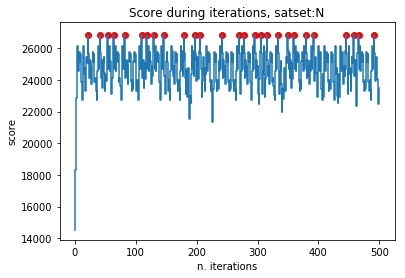

In [3]:
def plot_iterations(rdseed, satset='N', c=20, s=78, tabu_size=6, n_iter=500, nh_size=17):
    np.random.seed(rdseed)
    idx = np.random.randint(0, 1000)
    p = get_problem(satset, c, s, idx)
    solver = TabuSearchSATSolver(p, tabu_size, n_iter, nh_size ,idx)
    best, score = solver.run(verbose=False)

    x = np.arange(len(solver.iteration_best))
    y = solver.iteration_best
    plt.step(x, y, label='pre (default)')

    iters = np.array(solver.iteration_best)
    x = np.argwhere(iters == np.amax(iters)).flatten()
    plt.scatter(x=x, y=iters[x], c='red')
    plt.xlabel('n. iterations')
    plt.ylabel('score')
    plt.title('Score during iterations, satset:'+satset)
rdseed=42
plot_iterations(rdseed)

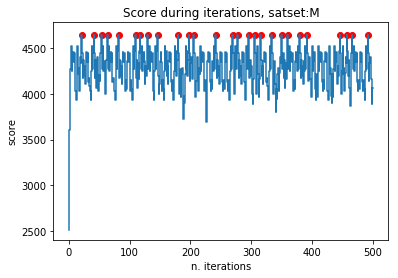

In [4]:
plot_iterations(rdseed=rdseed, satset='M', c=20, s=78, tabu_size=6, n_iter=500, nh_size=17)

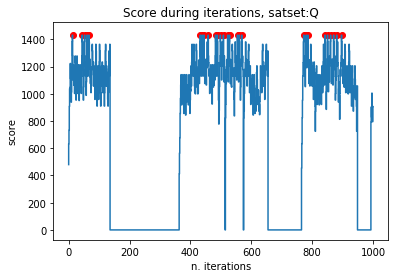

In [5]:
# satsets = ['M', 'N', 'Q', 'R', 'A']
plot_iterations(rdseed, satset='Q', c=20, s=78, tabu_size=4, n_iter=1000, nh_size=15)

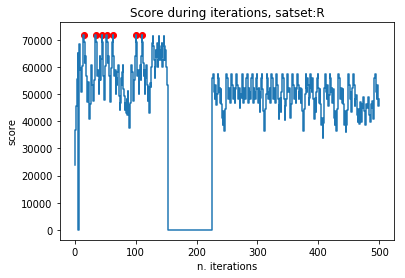

In [6]:
plot_iterations(rdseed, satset='R', c=20, s=78, tabu_size=6, n_iter=500, nh_size=17)

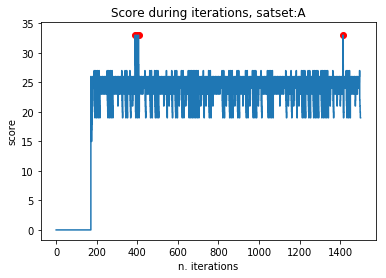

In [7]:
plot_iterations(rdseed, satset='A', c=20, s=88, tabu_size=7, n_iter=1500, nh_size=20)

n. of clauses: 88

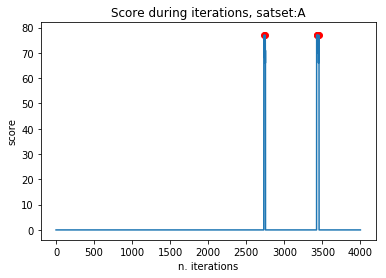

In [8]:
plot_iterations(3, satset='A', c=20, s=91, tabu_size=6, n_iter=4000, nh_size=17)

n. of clauses: 91.

It is pretty clear, on which instances TS will have biggest problems to obtain any optimum.

## Pivot experiment

I let TS to run on all instances of size 20, without searching the parameter grid. 

**Note:** I tried to run TS also on instances with **50 variables**, but it was not able to find any solution. Not even suboptimal.

Tabu size was set to 10 and 100; and neighborhood size to 100, 1000.

In [9]:
path = './results'
files = [f for f in glob.glob(path + "/**/*.csv", recursive=True)]

# filenames = [f for f in files]
results = []
for f in np.sort(files):
    info = [int(n) for n in re.findall(r'\d+', f.split('/')[3])]
    results.append({
        "data": pd.read_csv(f),
        "inst_type": re.findall(r'[A-Z]', f)[-1],
        "n_vars": info[0],
        "n_clauses": info[1],
        "tabu_size": info[2],
        "n_iterations": info[3]
    })

## Error rates

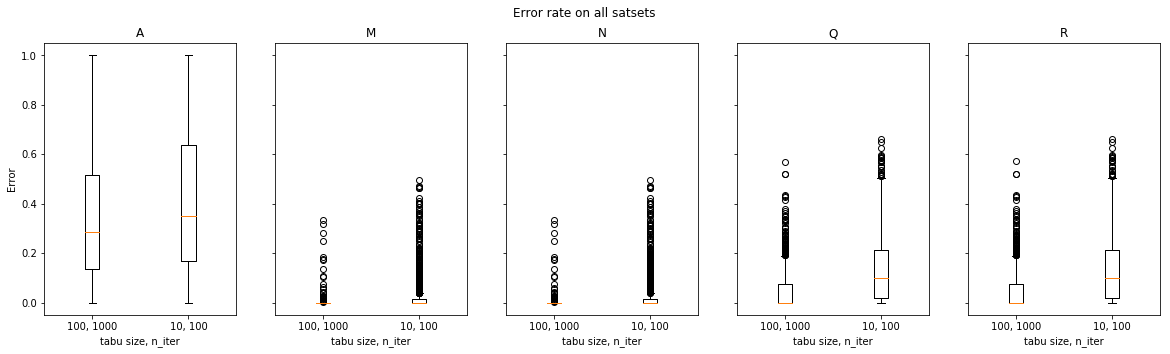

In [10]:
fig, ax = plt.subplots(nrows=1, ncols=5, sharey=True, figsize=(20,5))
for i in range(1, len(results), 2):
    d_this = results[i]['data']
    d_prev = results[i-1]['data']
    a = ax[int((i-1)/2)]
    a.boxplot([d_this.eps, d_prev.eps])
    a.set(title=results[i]['inst_type'] )
    a.set_xticklabels([str(results[i]['tabu_size'])+", "+str(results[i]['n_iterations']), str(results[i-1]['tabu_size'])+", "+str(results[i-1]['n_iterations'])])
    a.set_xlabel('tabu size, n_iter')
ax[0].set_ylabel('Error')
plt.suptitle('Error rate on all satsets')
plt.show()

In the graphs above we can see, how TS did on all instances. 

Size of neighborhood was set to 10 -> 50% flips on all possible positions.

Mean error was rising with the difficulty of satset, and falling with higher number of `tabu_size` and `n_instances`. 

* Fortunately, TS was able to find at least suboptimal solution on each instance from M, N, Q, R. 

    * Therefore relative error (maximum of all errors) is below:
    
        * *0.5:* on M, N
        * *0.7:* on Q, R
        
    * Of course, with higher number of iterations, I was able to obtain smaller error.
    
* Unfortunately, TS was not able to find even suboptimal solutions for some of the instances:

In [11]:
print(str(results[0]['data'].eps[results[0]['data'].eps == 1].sum()) + " of no-solution, of " + str(results[0]['data'].shape[0]) + " instances")

51.0 of no-solution, of 215 instances


which is almost a quarter of the whole satset.

## Optimum reached 
after how many iterations? 

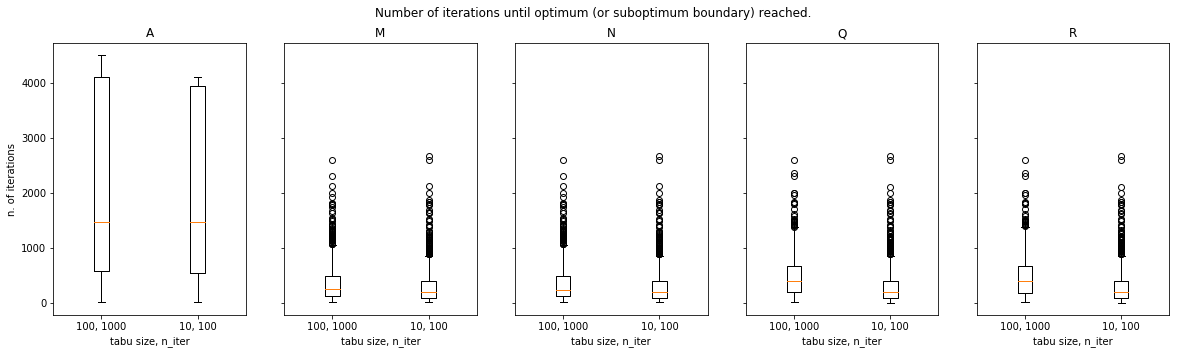

In [12]:
fig, ax = plt.subplots(nrows=1, ncols=5, sharey=True, figsize=(20,5))
for i in range(1, len(results), 2):
    d_this = results[i]['data']
    d_prev = results[i-1]['data']
    a = ax[int((i-1)/2)]
    a.boxplot([d_this.reached, d_prev.reached])
    a.set(title=results[i]['inst_type'] )
    a.set_xticklabels([str(results[i]['tabu_size'])+", "+str(results[i]['n_iterations']), str(results[i-1]['tabu_size'])+", "+str(results[i-1]['n_iterations'])])
    a.set_xlabel('tabu size, n_iter')
ax[0].set_ylabel('n. of iterations')
plt.suptitle('Number of iterations until optimum (or suboptimum boundary) reached.')
plt.show()

Not many iterations were neeeded on the easier satsets -> mean was only a few hundreds. 

However, we can see, that TS has **strong** iterative power, since it was able to obtain optimal solutions after more iterations.

**Note:** Remember, that I was stopping TS, if *no solution was found* after $2^{11}$ iterations.

# Parameter grid search (GS) 

## 20 samples

Below are functions providing grid-search over chosen parameters of TS. 

Each run I set different parameters for TS, on various number of samples from satsets (since grid search is an exhaustive method).

In [13]:
def get_best_parameters(satset, c, s, num):
    filename = f"data/wuf-{satset}/wuf{c}-{s}-{satset}/wuf{c}-0{num}.mwcnf"
    inst_lines = [line.rstrip('\n') for line in open(filename)]
    p = Problem(inst_lines, id=num)
    cnt = 0
    for tabu_size in range(1, 10, 1):
        for n_iterations in range(1000, 4000, 1000):
            for nh_size in range(1, 50, 5):
                cnt += 1
                state = np.random.randint(2, size=p.n_vars, dtype=bool).tolist()
                solver = TabuSearchSATSolver(p, state, tabu_size, n_iterations, neighborhood_size=nh_size, max_score=10540)
                best, score = solver.run(verbose=False)
                print((score, tabu_size, n_iterations, nh_size), end=', ')
                if score > 0:
                    print("score > 0")

    print(cnt)
# get_best_parameters('M', 50, 201, 123)

In [14]:
def get_sample_stats(sample, problems, tabu_size, n_iterations, nh_size, verbose=True):
    errors = []
    iterations = []
    for p in problems:
        if p.n_vars > 20:
            print("FRAUD!", (p.id))
        solver = TabuSearchSATSolver(p, int(tabu_size), int(n_iterations), 
                                     neighborhood_size=nh_size, initial_state=p.id, max_score=sample.loc[p.id].weight)
        best, score = solver.run(verbose=False)
        errors.append(ut.get_error(score, sample.loc[p.id].weight))
        iterations.append(solver.iteration_best.index(score) if score != 0 else len(solver.iteration_best))

    res = {
        'n_iterations': n_iterations,
        'tabu_size': tabu_size,
        'nh_size': nh_size,
        'max_relative_error': np.max(errors),
        'mean_relative_error': np.mean(errors),
        'std_relative_error': np.std(errors),
        'mean_reached': np.mean(iterations),
        'std_reached': np.std(iterations),
    }
    if verbose:
        print(res)
    return res

During parameter-grid-search, I was obtaining 

* max_relative_error,
* mean_relative_error,
* std_relative_error,
* mean_reached,
* std_reached

from different sample sizes, with fixed random seed.

**Since my algorithm is randomized, I used id of each instance, as a random seed for initial state and future neighborhood lookup.**

First I ran GS on 20 samples from M satset, with sampling random seed of 42. 

### Lowest relative error (RE)

below in the code cell is a explanation of shortened column names:

In [15]:
renamed = {
        'n_iterations': 'n_it',
        'tabu_size': 'ts',
        'nh_size': 'nhs',
        'max_relative_error': 'max_RE',
        'mean_relative_error': 'mean_RE',
        'std_relative_error': 'std_RE',
        'mean_reached': 'mean_reach',
        'std_reached': 'std_reach'
}
order = ['max_relative_error', 'mean_relative_error', 'std_relative_error', 'mean_reached', 'std_reached']
order_param = ['n_iterations', 'nh_size', 'tabu_size']

In [16]:
df = pd.read_csv(f'./param_search/param-search-M-20-42.csv')
df = df.reindex(order + order_param, axis=1)
display(df.sort_values(by=order, ascending=True).rename(columns=renamed).head(5))
for col in order_param:
    print("GS params for "+col+":\t", df[col].unique())

max_RE  mean_RE  std_RE  mean_reach   std_reach  n_it  nhs  ts
17     0.0      0.0     0.0       236.4  209.098398   500   16   5
22     0.0      0.0     0.0       236.4  209.098398   750   16   5
27     0.0      0.0     0.0       236.4  209.098398  1000   16   5
49     0.0      0.0     0.0       243.0  224.055127   500   20  10
54     0.0      0.0     0.0       243.0  224.055127   750   20  10

GS params for n_iterations:	 [ 500  750 1000]
GS params for nh_size:	 [12 14 16 18 20]
GS params for tabu_size:	 [ 3  5  7 10 12 15]



* Above are 5 best relative errors for the M satset. 

* Results are in ascending order: \['max_relative_error', 'mean_relative_error', 'std_relative_error', 'mean_reached', 'std_reached'\].

TS is doing great, even with small number of iterations.

Let's take a look on other satsets:

In [17]:
for satset in ['N', 'Q', 'R']:
    df = pd.read_csv(f'./param_search/param-search-{satset}-20-42.csv')
    df = df.reindex(order + order_param, axis=1)
    print('SATSET:', satset)
    display(df.sort_values(by=order, ascending=True).rename(columns=renamed).head(5))
    for col in order_param:
        print("GS params for "+col, df[col].unique())
    print()

SATSET: N


max_RE  mean_RE  std_RE  mean_reach   std_reach  n_it  nhs  ts
17     0.0      0.0     0.0       236.4  209.098398   500   16   5
22     0.0      0.0     0.0       236.4  209.098398   750   16   5
27     0.0      0.0     0.0       236.4  209.098398  1000   16   5
49     0.0      0.0     0.0       243.0  224.055127   500   20  10
54     0.0      0.0     0.0       243.0  224.055127   750   20  10

GS params for n_iterations [ 500  750 1000]
GS params for nh_size [12 14 16 18 20]
GS params for tabu_size [ 3  5  7 10 12 15]

SATSET: Q


max_RE   mean_RE    std_RE  mean_reach   std_reach  n_it  nhs  ts
41  0.093643  0.012184  0.025296      355.75  272.074048  1000   14   7
36  0.093643  0.013335  0.025239      332.15  236.126084   750   14   7
40  0.130584  0.013231  0.030970      389.85  293.762706  1000   12   7
25  0.141026  0.018092  0.036403      395.50  289.424342  1000   12   5
10  0.208763  0.016308  0.046378      466.95  323.577576  1000   12   3

GS params for n_iterations [ 500  750 1000]
GS params for nh_size [12 14 16 18 20]
GS params for tabu_size [ 3  5  7 10 12 15]

SATSET: R


max_RE   mean_RE    std_RE  mean_reach   std_reach  n_it  nhs  ts
41  0.094136  0.012309  0.025535      355.75  272.074048  1000   14   7
36  0.094136  0.013465  0.025475      332.15  236.126084   750   14   7
40  0.130821  0.013335  0.031081      411.15  286.977399  1000   12   7
25  0.140051  0.016398  0.036418      436.50  305.549423  1000   12   5
35  0.209624  0.018177  0.046595      367.55  250.798221   750   12   7

GS params for n_iterations [ 500  750 1000]
GS params for nh_size [12 14 16 18 20]
GS params for tabu_size [ 3  5  7 10 12 15]



Again, TS is doing well, but it seems, that it needs more iterations to obtain the lowest error, in Q, R satsets.

Now let's take a look on A satset of 

* 20 samples, 
* 88 and 91 clauses,
* random seed 21:

In [18]:
satset = 'A'
for s in [88, 91]:
    df = pd.read_csv(f'./param_search/param-search-{satset}-s{s}-20-21.csv')
    df = df.reindex(order + order_param, axis=1)
    print('SATSET:', satset, ", s:", s)
    display(df.sort_values(by=order, ascending=True).rename(columns=renamed).head(5))
    for col in order_param:
        print("GS params for "+col, df[col].unique())
    print()

SATSET: A , s: 88


max_RE   mean_RE    std_RE  mean_reach   std_reach  n_it  nhs  ts
5     1.0  0.328970  0.283328     1239.35  854.307806  1000   20   7
2     1.0  0.328970  0.283328     1275.25  836.928484  1000   20   4
8     1.0  0.361080  0.300558     1204.30  857.024335  1000   20  10
1     1.0  0.386079  0.353424     1352.10  868.875877  1000   15   4
4     1.0  0.388757  0.355322     1311.20  884.238916  1000   15   7

GS params for n_iterations [1000]
GS params for nh_size [10 15 20]
GS params for tabu_size [ 4  7 10]

SATSET: A , s: 91


max_RE   mean_RE    std_RE  mean_reach   std_reach  n_it  nhs  ts
5     1.0  0.787059  0.377103     2047.75  788.649724  1000   20   7
8     1.0  0.787059  0.377103     2047.75  788.649724  1000   20  10
1     1.0  0.787059  0.377103     2074.85  747.027662  1000   15   4
2     1.0  0.787059  0.377103     2074.85  747.027662  1000   20   4
0     1.0  0.789559  0.372009     2164.20  653.944233  1000   10   4

GS params for n_iterations [1000]
GS params for nh_size [10 15 20]
GS params for tabu_size [ 4  7 10]



It seems, that not even 1000 iterations were enough to obtain at least suboptimal solutions.

We can see in mean_reached, that with smaller number of clauses, around 1200 iterations were needed to obtain at least suboptimal solutions, with standard error of ~800. 

TS needs very high neighborhood size to obtain results that are OK.

**Note:** I know, that the parameter grid was not very big, but still it took a lot of computational time to obtain at least these results.

### Highest relative error

Now let's take a look on parameters, which provided the highest relative error:

In [19]:
for satset in ['M', 'N', 'Q', 'R']:
    df = pd.read_csv(f'./param_search/param-search-{satset}-20-42.csv')
    df = df.reindex(order + order_param, axis=1)
    print('SATSET:', satset)
    display(df.sort_values(by=order, ascending=False).rename(columns=renamed).head(5))
    for col in order_param:
        print("GS params for "+col, df[col].unique())
    print()
satset = 'A'
for s in [88, 91]:
    df = pd.read_csv(f'./param_search/param-search-{satset}-s{s}-20-21.csv')
    df = df.reindex(order + order_param, axis=1)
    print('SATSET:', satset, ", s:", s)
    display(df.sort_values(by=order, ascending=False).rename(columns=renamed).head(5))
    for col in order_param:
        print("GS params for "+col, df[col].unique())
    print()

SATSET: M


max_RE   mean_RE    std_RE  mean_reach   std_reach  n_it  nhs  ts
60  0.351612  0.034849  0.100409      279.40  243.224464   500   12  12
65  0.351612  0.034849  0.100409      279.40  243.224464   750   12  12
45  0.351612  0.034849  0.100409      278.20  244.123043   500   12  10
50  0.351612  0.034849  0.100409      278.20  244.123043   750   12  10
46  0.351612  0.033517  0.100686      242.15  228.435171   500   14  10

GS params for n_iterations [ 500  750 1000]
GS params for nh_size [12 14 16 18 20]
GS params for tabu_size [ 3  5  7 10 12 15]

SATSET: N


max_RE   mean_RE    std_RE  mean_reach   std_reach  n_it  nhs  ts
60  0.351872  0.034836  0.100382      279.50  243.631792   500   12  12
65  0.351872  0.034836  0.100382      279.50  243.631792   750   12  12
45  0.351872  0.034836  0.100382      277.70  244.928990   500   12  10
50  0.351872  0.034836  0.100382      277.70  244.928990   750   12  10
46  0.351872  0.033506  0.100658      242.15  228.435171   500   14  10

GS params for n_iterations [ 500  750 1000]
GS params for nh_size [12 14 16 18 20]
GS params for tabu_size [ 3  5  7 10 12 15]

SATSET: Q


max_RE   mean_RE    std_RE  mean_reach   std_reach  n_it  nhs  ts
4   0.375386  0.134080  0.100314      219.25  211.105868   500   20   3
9   0.375386  0.134080  0.100314      219.25  211.105868   750   20   3
14  0.375386  0.134080  0.100314      219.25  211.105868  1000   20   3
3   0.375386  0.105755  0.104300      227.15  214.842564   500   18   3
8   0.375386  0.101164  0.106803      262.40  235.315618   750   18   3

GS params for n_iterations [ 500  750 1000]
GS params for nh_size [12 14 16 18 20]
GS params for tabu_size [ 3  5  7 10 12 15]

SATSET: R


max_RE   mean_RE    std_RE  mean_reach   std_reach  n_it  nhs  ts
4   0.375411  0.134250  0.100223      219.25  211.105868   500   20   3
9   0.375411  0.134250  0.100223      219.25  211.105868   750   20   3
14  0.375411  0.134250  0.100223      219.25  211.105868  1000   20   3
3   0.375411  0.105897  0.104291      227.15  214.842564   500   18   3
8   0.375411  0.101300  0.106801      262.40  235.315618   750   18   3

GS params for n_iterations [ 500  750 1000]
GS params for nh_size [12 14 16 18 20]
GS params for tabu_size [ 3  5  7 10 12 15]

SATSET: A , s: 88


max_RE   mean_RE    std_RE  mean_reach   std_reach  n_it  nhs  ts
0     1.0  0.585874  0.372381     1710.30  832.577270  1000   10   4
6     1.0  0.561239  0.358450     1597.10  849.169942  1000   10  10
3     1.0  0.555825  0.360071     1581.15  856.510611  1000   10   7
7     1.0  0.390212  0.354157     1225.25  848.382454  1000   15  10
4     1.0  0.388757  0.355322     1311.20  884.238916  1000   15   7

GS params for n_iterations [1000]
GS params for nh_size [10 15 20]
GS params for tabu_size [ 4  7 10]

SATSET: A , s: 91


max_RE   mean_RE    std_RE  mean_reach   std_reach  n_it  nhs  ts
3     1.0  0.839559  0.327008     2231.60  614.528876  1000   10   7
6     1.0  0.839559  0.327008     2231.60  614.528876  1000   10  10
4     1.0  0.837059  0.333168     2142.25  721.177778  1000   15   7
7     1.0  0.837059  0.333168     2142.25  721.177778  1000   15  10
0     1.0  0.789559  0.372009     2164.20  653.944233  1000   10   4

GS params for n_iterations [1000]
GS params for nh_size [10 15 20]
GS params for tabu_size [ 4  7 10]



M, N satsets:

* small nh_size is causing bad results

* big tabu_size is not helping

* less iterations - bigger error.

Q, R satsets:

* big nh_size with small tabu_size is not helping

* less iterations are also a problem.

A satsets:

* looks like more clauses are causing more problems, since more iterations are needeed to obtain at least suboptimal solutions.

* small nh_size is not helping at all

* tabu_size does not seem to matter that much.

## 50 sample size

with random seed = 21 (24 and 42 for A, because there are no full 1000 instances in these satsets)

### Lowest relative error

First, let's take a look on 50 samples from easier satsets:

In [20]:
for satset in ['M', 'N', 'Q', 'R']:
    df = pd.read_csv(f'./param_search/param-search-{satset}-50-21.csv')
    df = df.reindex(order + order_param, axis=1)
    print('SATSET:', satset)
    display(df.sort_values(by=order, ascending=True).rename(columns=renamed).head(5))
    for col in order_param:
        print("GS params for "+col, df[col].unique())
    print()

SATSET: M


max_RE  mean_RE    std_RE  mean_reach   std_reach  n_it  nhs  ts
42  0.010787  0.00022  0.001525  215.061224  185.719056   500   17   6
57  0.010787  0.00022  0.001525  215.061224  185.719056   500   17   7
40  0.010787  0.00022  0.001525  230.122449  223.406341   500   15   6
55  0.010787  0.00022  0.001525  230.122449  223.406341   500   15   7
70  0.010787  0.00022  0.001525  231.836735  225.345481   500   15   8

GS params for n_iterations [100 250 500]
GS params for nh_size [15 16 17 19 20]
GS params for tabu_size [4 5 6 7 8 9]

SATSET: N


max_RE   mean_RE    std_RE  mean_reach   std_reach  n_it  nhs  ts
42  0.010826  0.000221  0.001531  215.061224  185.719056   500   17   6
57  0.010826  0.000221  0.001531  215.061224  185.719056   500   17   7
40  0.010826  0.000221  0.001531  230.122449  223.406341   500   15   6
55  0.010826  0.000221  0.001531  230.122449  223.406341   500   15   7
70  0.010826  0.000221  0.001531  231.836735  225.345481   500   15   8

GS params for n_iterations [100 250 500]
GS params for nh_size [15 16 17 19 20]
GS params for tabu_size [4 5 6 7 8 9]

SATSET: Q


max_RE   mean_RE    std_RE  mean_reach   std_reach  n_it  nhs  ts
6   0.118197  0.012744  0.030557  444.693878  365.620535  1500   14   3
2   0.118197  0.017480  0.031649  320.285714  220.463519  1000   14   3
46  0.119029  0.010890  0.028045  380.469388  304.468832  1500   14   8
45  0.119029  0.012864  0.029918  481.571429  368.060332  1500   13   8
5   0.148912  0.020798  0.041187  460.571429  388.882596  1500   13   3

GS params for n_iterations [1000 1500]
GS params for nh_size [12 13 14 15]
GS params for tabu_size [3 4 5 6 7 8]

SATSET: R


max_RE   mean_RE    std_RE  mean_reach   std_reach  n_it  nhs  ts
47  0.111513  0.011208  0.026225  399.265306  357.611508  1500   15   8
46  0.119951  0.010925  0.028116  381.000000  305.690253  1500   14   8
45  0.119951  0.012885  0.029974  472.428571  358.777061  1500   13   8
41  0.119951  0.017172  0.032777  381.142857  282.834487  1000   13   8
28  0.159293  0.013435  0.033826  504.632653  366.921261  1500   12   6

GS params for n_iterations [1000 1500]
GS params for nh_size [12 13 14 15]
GS params for tabu_size [3 4 5 6 7 8]



M, N satsets:

* nh_size = 17 and 15 are the winners

* tabu_size = 6, 7 similarly as in 20-sampled-set

* more iterations - smaller error.

Q, R satsets:

* nh_size 14 and 15 are the winners

* tabu_size of 3 or 8

* and of course more iterations -> better results

Overall, it looks similar to 20-sampled-set.

Now let's take a look on the hardest sets, obtained by two 50-sample subsets, with random seeds 24 and 42 (and different GS set):

In [21]:
satset = 'A'
for s in [88, 91]:
    df = pd.concat([pd.read_csv(f'./param_search/param-search-{satset}-s{s}-50-24.csv'), 
                    pd.read_csv(f'./param_search/param-search-{satset}-s{s}-50-42.csv')])
    df = df.reindex(order + order_param, axis=1)
    print('SATSET:', satset, ", s:", s)
    display(df.sort_values(by=order, ascending=True).rename(columns=renamed).head(5))
    for col in order_param:
        print("GS params for "+col, df[col].unique())
    print()

SATSET: A , s: 88


max_RE   mean_RE    std_RE  mean_reach    std_reach  n_it  nhs  ts
8      1.0  0.227397  0.218841     1196.00  1318.856459  1000   20  20
11     1.0  0.239530  0.215609     1182.00  1326.764727  1000   20  50
5      1.0  0.240806  0.260468     1318.32  1355.282368  1500   20   6
8      1.0  0.240806  0.260468     1318.32  1355.282368  1500   20   7
2      1.0  0.246500  0.254143     1330.54  1390.024175  1500   20   5

GS params for n_iterations [1000 1500]
GS params for nh_size [10 15 20 17]
GS params for tabu_size [ 5 10 20 50  6  7]

SATSET: A , s: 91


max_RE   mean_RE    std_RE  mean_reach    std_reach  n_it  nhs  ts
2     1.0  0.713320  0.416618     3677.42  1437.398457  1000   20   5
5     1.0  0.736419  0.396620     3727.64  1324.152631  1000   20  10
1     1.0  0.744676  0.401341     3766.76  1332.277052  1000   15   5
2     1.0  0.751131  0.406451     3647.30  1542.647714  1500   20   5
8     1.0  0.752705  0.390341     3714.46  1359.798018  1000   20  20

GS params for n_iterations [1000 1500]
GS params for nh_size [10 15 20 17]
GS params for tabu_size [ 5 10 20 50  6  7]



It loooks like n_iterations is not an issue, if the neighborhood_size is big enough.

Tabu_size needs to be also pretty high.

What is sad, that i sniff a random walking TS, with intelligent state-search, since many iterations were needed to provide at least suboptimal solutions. 

An exhaustive search is done on many instances. This satset is just *HARD*.

### Highest relative error

In [22]:
for satset in ['M', 'N', 'Q', 'R']:
    df = pd.read_csv(f'./param_search/param-search-{satset}-50-21.csv')
    df = df.reindex(order + order_param, axis=1)
    print('SATSET:', satset)
    display(df.sort_values(by=order, ascending=False).rename(columns=renamed).head(3))
    for col in order_param:
        print("GS params for "+col, df[col].unique())
    print()
satset = 'A'
for s in [88, 91]:
    df = pd.concat([pd.read_csv(f'./param_search/param-search-{satset}-s{s}-50-24.csv'), 
                    pd.read_csv(f'./param_search/param-search-{satset}-s{s}-50-42.csv')])
    df = df.reindex(order + order_param, axis=1)
    print('SATSET:', satset, ", s:", s)
    display(df.sort_values(by=order, ascending=False).rename(columns=renamed).head(3))
    for col in order_param:
        print("GS params for "+col, df[col].unique())
    print()

SATSET: M


max_RE   mean_RE    std_RE  mean_reach   std_reach  n_it  nhs  ts
6   0.808519  0.030138  0.125011  198.428571  165.547946   250   16   4
21  0.808519  0.030138  0.125011  198.428571  165.547946   250   16   5
5   0.808519  0.021675  0.117844  215.122449  181.223803   250   15   4

GS params for n_iterations [100 250 500]
GS params for nh_size [15 16 17 19 20]
GS params for tabu_size [4 5 6 7 8 9]

SATSET: N


max_RE   mean_RE    std_RE  mean_reach   std_reach  n_it  nhs  ts
6   0.808813  0.030156  0.125068  198.428571  165.547946   250   16   4
21  0.808813  0.030156  0.125068  198.428571  165.547946   250   16   5
5   0.808813  0.021687  0.117890  215.122449  181.223803   250   15   4

GS params for n_iterations [100 250 500]
GS params for nh_size [15 16 17 19 20]
GS params for tabu_size [4 5 6 7 8 9]

SATSET: Q


max_RE   mean_RE    std_RE  mean_reach   std_reach  n_it  nhs  ts
40  0.290833  0.027873  0.066821  400.775510  295.810217  1000   12   8
44  0.290833  0.019977  0.050706  470.122449  359.283961  1500   12   8
8   0.259762  0.033806  0.063772  452.244898  386.949584  1000   12   4

GS params for n_iterations [1000 1500]
GS params for nh_size [12 13 14 15]
GS params for tabu_size [3 4 5 6 7 8]

SATSET: R


max_RE   mean_RE    std_RE  mean_reach   std_reach  n_it  nhs  ts
40  0.290837  0.034650  0.076290  392.571429  300.826209  1000   12   8
44  0.290837  0.022179  0.056825  482.346939  371.827893  1500   12   8
8   0.259863  0.036325  0.064812  447.857143  387.884529  1000   12   4

GS params for n_iterations [1000 1500]
GS params for nh_size [12 13 14 15]
GS params for tabu_size [3 4 5 6 7 8]

SATSET: A , s: 88


max_RE   mean_RE    std_RE  mean_reach    std_reach  n_it  nhs  ts
0     1.0  0.434589  0.331136     1914.50  1689.049037  1000   10   5
6     1.0  0.401116  0.309876     1804.06  1693.651728  1000   10  20
3     1.0  0.397706  0.313409     1838.94  1703.274475  1000   10  10

GS params for n_iterations [1000 1500]
GS params for nh_size [10 15 20 17]
GS params for tabu_size [ 5 10 20 50  6  7]

SATSET: A , s: 91


max_RE   mean_RE    std_RE  mean_reach    std_reach  n_it  nhs  ts
6      1.0  0.847754  0.314654     3953.38  1242.615434  1000   10  20
9      1.0  0.847754  0.314654     3953.38  1242.615434  1000   10  50
10     1.0  0.827174  0.336713     3890.10  1292.786947  1000   15  50

GS params for n_iterations [1000 1500]
GS params for nh_size [10 15 20 17]
GS params for tabu_size [ 5 10 20 50  6  7]



Bit of a disappointment is a tabu_size of ~4 and nh_size of ~15, but with small amount of iterations on easier satsets.

Small nh_size and big tabu_size shows bad parameter setting on hardest instances.

## Grid search - errors for different parameters

First, I iterated over vast number of parameters, on satset N:

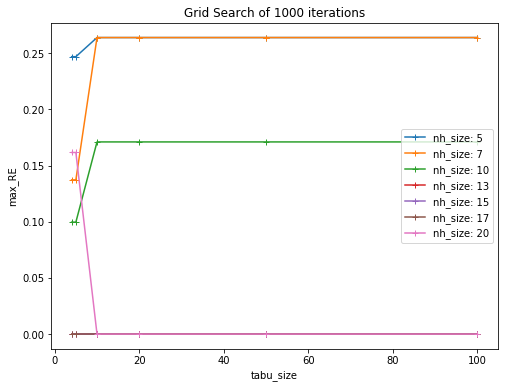

In [23]:
df = pd.read_csv('param_search/param-search-M-s78-20-87-exhaustive.csv')
df.nunique()
fig = plt.figure(figsize=(8, 6))
nh = df.nh_size.unique()
for i_nh in range(len(nh)):
    d = df[df.nh_size == nh[i_nh]]
    plt.plot(d.tabu_size, d.max_relative_error, marker='+', label='nh_size: '+str(nh[i_nh]))
plt.xlabel('tabu_size')
plt.ylabel('max_RE')
plt.title('Grid Search of 1000 iterations')
plt.legend()
plt.show()

Above we can see (maximal) relative error, while searching on 20 samples.

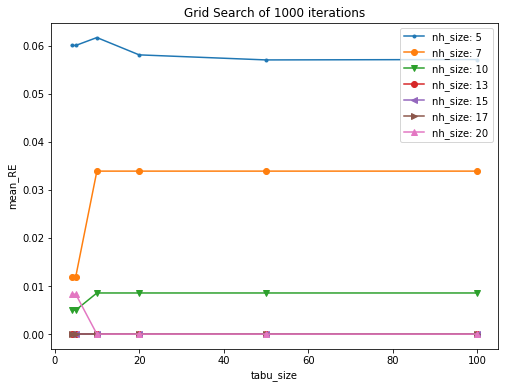

In [24]:
df = pd.read_csv('param_search/param-search-M-s78-20-87-exhaustive.csv')
df.nunique()
markers = ['.', 'o', 'v', 'o', '<', '>', '^']
fig = plt.figure(figsize=(8, 6))
nh = df.nh_size.unique()
for i_nh in range(len(nh)):
    d = df[df.nh_size == nh[i_nh]]
    plt.plot(d.tabu_size, d.mean_relative_error,marker=markers[i_nh], label='nh_size: '+str(nh[i_nh]))
plt.xlabel('tabu_size')
plt.ylabel('mean_RE')
plt.title('Grid Search of 1000 iterations')
plt.legend()
plt.show()

Above we can see mean RE, with different parameters. Higher neighborhood size does imply smaller error!

But we need to be careful about tabu_size. Also needs to be sufficiently large.

## 50 sample size

Below are errors for different parameters shown. Used 50 samples from each satset.

Each graph shows different error for different tabu_size.

Rows are differing neighborhood_size and columns are differing number of iterations.

**Note:** beware, y axis is in log scale.

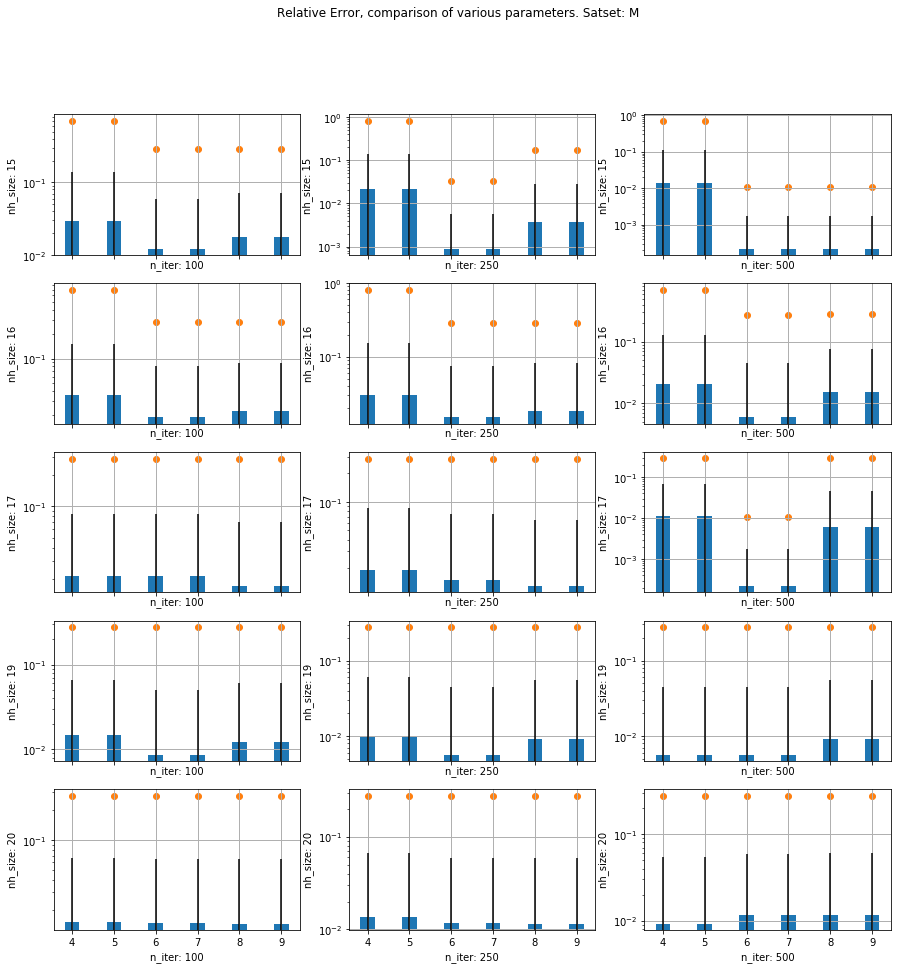

In [25]:
def plot_errors(satset, filename=None):
    if filename is None:
        filename = f'./param_search/param-search-{satset}-{50}-{21}.csv'
    df = pd.read_csv(filename)
    ts = df.tabu_size.unique()
    it = df.n_iterations.unique()
    nh = df.nh_size.unique()
    fig, ax = plt.subplots(nrows=len(nh), ncols=len(it), figsize=(15, 15), sharex=True)
    for i_it in range(len(it)):
        for i_nh in range(len(nh)):
            c1 = df.nh_size == nh[i_nh]
            c3 = df.n_iterations == it[i_it]
            d = df[c1 & c3]
            a = ax[i_nh, i_it]
            a.bar(x=ts, height=d.mean_relative_error, width=0.35, yerr=d.std_relative_error)
            a.scatter(x=ts, y=d.max_relative_error)
            a.set_yscale('log')
            a.set(ylabel='nh_size: '+str(nh[i_nh]), xlabel='n_iter: '+str(it[i_it]))
            a.grid( linestyle='-', linewidth=1)
    plt.suptitle('Relative Error, comparison of various parameters. Satset: '+satset)
    plt.show()
plot_errors('M')

Orange dots are the maximal (relative) error, the height of the bars shows mean and black lines denote standard error.

It looks like number of iterations on easier dataset is an issue only for smaller nh_size. 

Seems that tabu_size of 6,7 wins almost everytime.

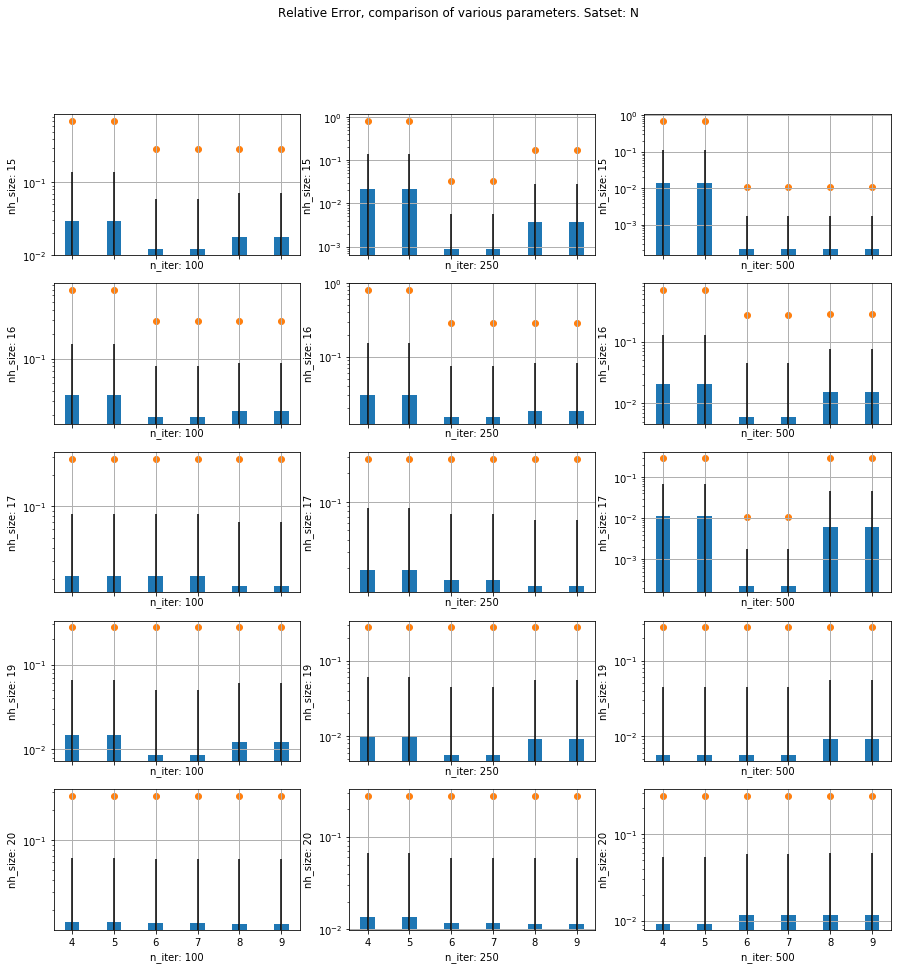

In [26]:
plot_errors('N')

Looks completely the same than the 'M' satset.

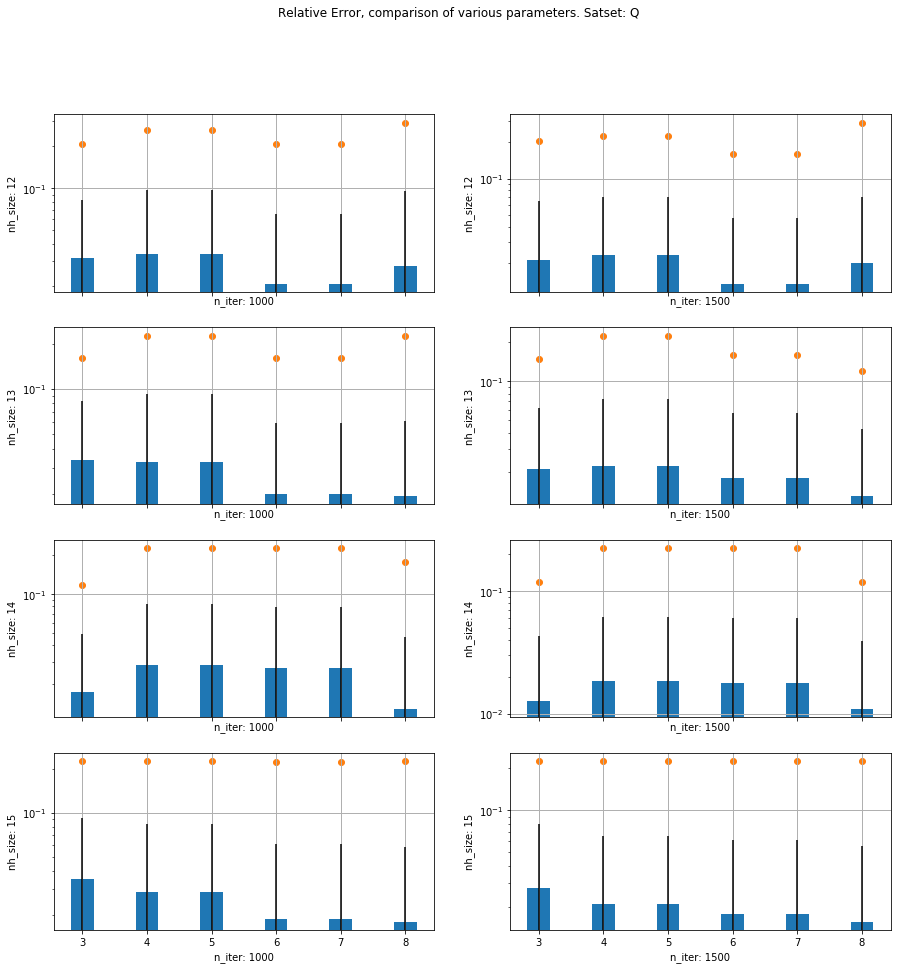

In [27]:
plot_errors('Q')

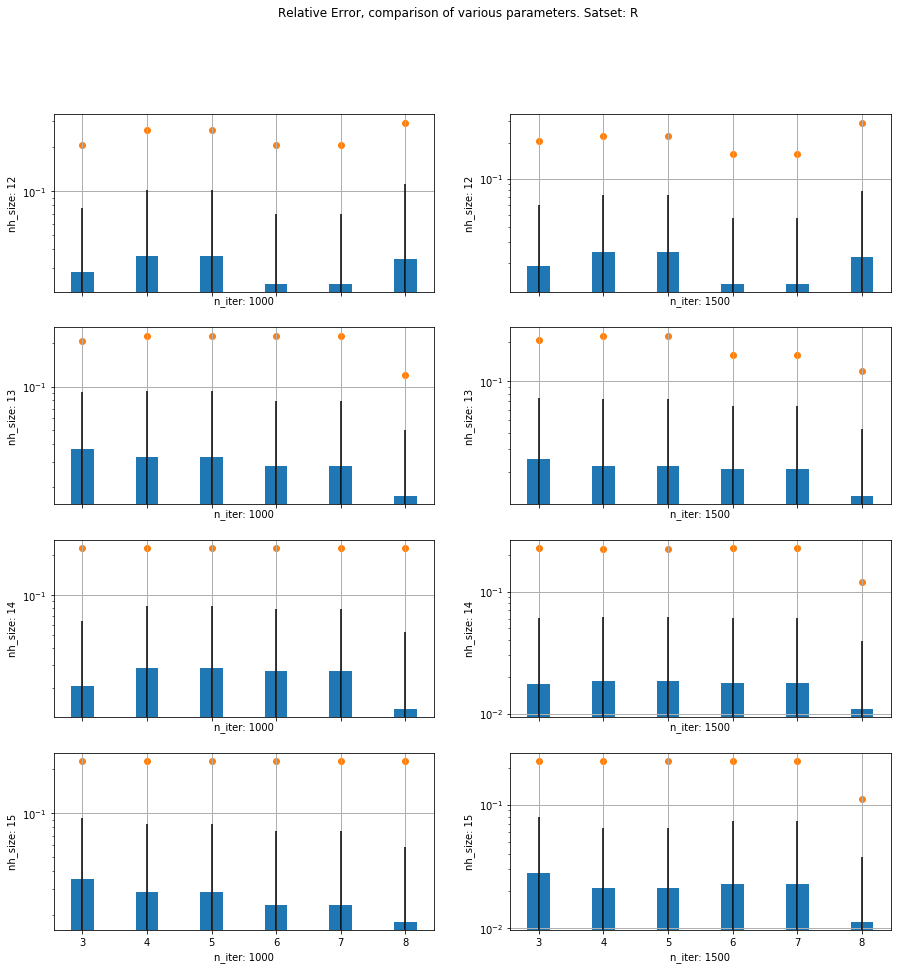

In [28]:
plot_errors('R')

In [29]:
filename=f'./param_search/param-search-A-s88-{50}-{24}.csv'
df = pd.read_csv(filename)
ts = df.tabu_size.unique()
it = df.n_iterations.unique()
nh = df.nh_size.unique()

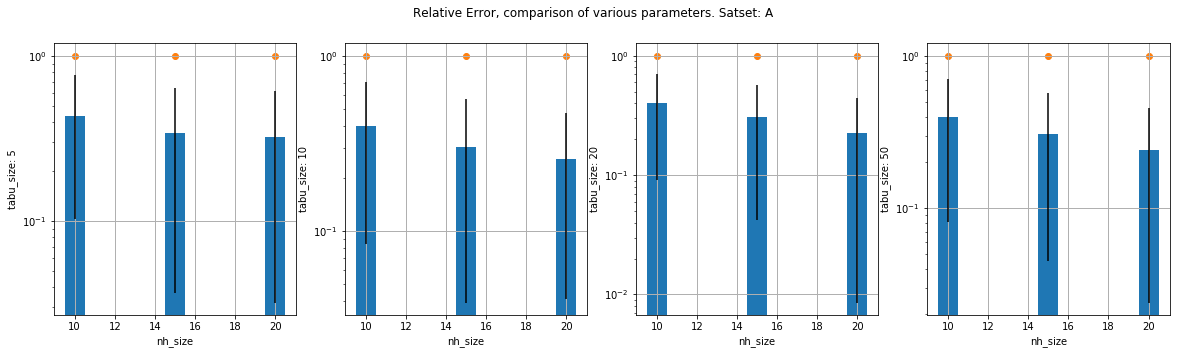

In [30]:
fig, ax = plt.subplots(nrows=len(it), ncols=len(ts), figsize=(20, 5))
for i_ts in range(len(ts)):
    c1 = df.tabu_size == ts[i_ts]
    d = df[c1]
    if d.empty:
        continue

    a = ax[ i_ts]
    a.grid( linestyle='-', linewidth=1)
    a.bar(x=d.nh_size, height=d.mean_relative_error, width=1, yerr=d.std_relative_error)
    a.scatter(x=d.nh_size, y=d.max_relative_error)
    a.set_yscale('log')
    a.set(ylabel='tabu_size: '+str(ts[i_ts]), xlabel='nh_size')
plt.suptitle('Relative Error, comparison of various parameters. Satset: '+satset)
plt.show()

It seems that the mean error is falling with increasing tabu_size, but stops somewhere between 20 and 50.

So again, bigger neighborhood, smaller errors.

This doesn't apply on tabu_size. It needs to be rather somewhere between 4-10.

* Algorithms and implementation
    * Byly použity techniky (algoritmy, datové struktury) adekvátní problému?
        * I used queue for tabu list, clause was represented as list of dictionaries. Tabu Search has parameters for sizes of neighborhood, tabu list and maximum iterations. 
    * Byly použity pokročilé techniky? (např. adaptační mechanismy)
        * I extend the number of iterations, if no optimum or suboptimum is found. 
    * Jsou některé postupy originálním přínosem autora?
        * I tried to use more implementations of neighborhood, which, unfortunately, were not working.
        * Some other implementation of functions such as "satisfies" or "neighborhood" were used, but I chose ones, working the best.

* Application of Heuristic
    * Jakou metodou autor hledal nastavení parametrů?
        * Exhaustive Parameters Grid Search was used, on smaller samples. Then, more precise parameters were chosen, to provide best parameters for each instance set.
    * Jak byly plánovány experimenty a jaké byly jejich otázky?
        * I planned experiments in a way to cover as many instances as possible, with not-so-exhaustive methods. 
        * Parameters of the model were questioned, and the grid search was ran on each dataset.
    * Na jak velkých instancích je heuristika schopna pracovat?
        * Unfortunately, this heuristic cannot be applied to instances with higher number of variables. 
        * I tried (you need to trust me) exhaustive grid search with many parameters on one instance with 50 variables, but no solution, not even suboptimal was found. Iteration limit was set to $2^{13}$, which is a lot. 
    * Jestliže práce heuristiky není uspokojivá, jak systematické byly snahy autora zjednat nápravu?
        * Implementation of other neighborhood functions described above, and also more systematical bit-flips. No better results.

* Experimental evaluation of heuristic
    * Jak dalece jsou závěry vyhodnocení doloženy experimentálně?
        * I did grid-search on 20 and 50 samples from each set.
        * Best and worse parameters were found, watching mean and std error (deviation) and relative error (n. of iterations until solution as addition)
        * From the experiments and gridsearch, it is clear, that the iterative power of TS is pretty strong, but have problems with more variables.
    * Je interpretace experimentů přesvědčivá?
        * Basic statistical methods were used to show the ability of finding solution with some relative error.
    * Pokud je algoritmus randomizovaný, byla tato skutečnost vzata v úvahu při plánování experimentů?
        * Yes, each experiment is reproducible, since I was using random seeds not only for choosing samples, but also for each run of TS (setting random seed as id of the instance)
    * Je možno z experimentů usoudit na iterativní sílu heuristiky?
        * Yes, it is clear from the experiments. More iterations means smaller error.
    * Jsou výsledky experimentů srozumitelně prezentovány (grafy, tabulky, statistické metody)?
        * I used means, standard errors (deviations) of errors and number of iterations until any optimum reached. All noted, while watching experiments.
        * Tables of best and worse results from experiments were provided.
        * I showed the error on graphs, for better comprehension.